In [1]:
from Functions import simple_models_hold_out, hold_out, optimise_occupancy, \
adjacent_co2, load_data, load_occupancy, load_lists, plot_estimates
import numpy as np

To load a dd_list, we first need to find the start and end time for
the corresponding occupancy:

In [2]:
dates = ['2022_24_11', '2022_30_11', '2022_07_12',  '2022_09_12', '2022_14_12']

filename_n = 'data/N_' + dates[0] + '.csv'
N_list, start_time, end_time = load_occupancy(filename_n, n_zones=27)
len(N_list), np.array(N_list[-1]), N_list[2]

(28,
 array([17, 13, 11, 11, 13, 16, 16, 13, 14, 13, 13, 19, 17, 17, 17, 15, 17,
        15, 15, 15]),
 [])

The N_list from load occupancy contains n_zones + 1 lists of occupancy
counted in the period, and is simply empty if the zone does not have data.
Along with this, we also got a start and end time which is now used to find
the correponding CO2 levels:

In [3]:
filename_co2 = 'data/co2_' + dates[0] + '.csv'
dd_list = load_data(filename_co2, start_time, end_time)
len(dd_list), dd_list[-1][:3], dd_list[2][:3]

(28,
 [[datetime.datetime(2022, 11, 24, 11, 0), 612.1185266332714],
  (datetime.datetime(2022, 11, 24, 11, 15), 1058.8146743982488),
  (datetime.datetime(2022, 11, 24, 11, 30), 1059.31337984861)],
 [[datetime.datetime(2022, 11, 24, 11, 0), 555.5901475703059],
  (datetime.datetime(2022, 11, 24, 11, 15), 637.0009125158241),
  (datetime.datetime(2022, 11, 24, 11, 30), 657.7038489323096)])

The dd_list is of the same length as the N_list, but contains tuples of
(time, co2) for each zone. The co2 level is a smoothed estimate of the true level based on measurements up to each occupancy count. One can specify whether to use an exponential moving average filter or a Kalman filter for this.

When dealing with more than one consecutive function, the structure becomes a bit more complex. Instead of each zone simply containing the list of data, it must now contain a list of periods, each of which is an entry like the above N_list and dd_list. For this we use

In [4]:
N_list, dd_list = load_lists(dates)
np.array(N_list[-1][-1]), len(N_list[-1])

(array([ 0,  1,  3,  5,  7,  9,  9, 13, 16, 16, 13, 16, 15, 15, 16, 15, 17,
        14, 11, 13, 14, 15, 14, 15, 15, 17, 15, 15, 16, 16, 15, 15, 13, 15,
        15]),
 5)

There are 5 periods in this data. This can now be used to get optimal parameters for estimating both CO2 and occupancy. First of all, to calculate an estimate we pass a set of parameters along with the co2, adjacent co2 and N_lists to the estimate functions. We find the adjacent CO2 levels first

In [5]:
adj_list = adjacent_co2(dd_list, use_adjacent=False)
print(np.array(adj_list[-1][-1])) # 0's if we aren't using the replacement co2
adj_list = adjacent_co2(dd_list)
print(np.array(adj_list[-1][-1])) # use replacement co2 by default

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 489.69314601  519.42755921  616.6881662   616.6881662   707.28737741
  751.63403034  834.99190167  918.8756841   978.56812964 1069.42573256
 1144.99972628 1144.99972628 1237.98791211 1212.59400583 1276.53116842
 1276.53116842 1280.34860778 1255.19577744 1255.54888978 1255.54888978
 1248.89443536 1245.68748685 1278.49903142 1296.04639213 1296.04639213
 1257.5        1292.40197967 1291.84613884 1267.95351059 1232.48147631
 1252.40106019 1252.         1241.04422654 1234.00074418 1266.18869062]


Now to producing estimates, the parameters used are from optimisation done on the data available in the repository, but must simply be a tuple-like of length 4. Variable names here mirror those inside functions in the rest of the code.

In [6]:
import pandas as pd
from Functions import N_estimate, C_estimate
N, C, C_adj = N_list[-1][-1], np.array(dd_list[-1][-1])[:, 1], adj_list[-1][-1]
V = 150
parameters = pd.read_csv('parameters/testing_2022_07_12.csv').values

C_est = C_estimate(x=parameters[-1][1:], C=C, C_adj=C_adj, N=N, V=V)
N_est = N_estimate(x=parameters[-1][1:], C=C, C_adj=C_adj, V=V)

print(np.round(C_est - np.array(C[1:], dtype=int), 0), '\n', N_est - N[1:])

[-153.  -24.   96.  224.  348.   83.  216.  367.  283.   87.  267.  215.
  148.  196.  136.  256.   74. -106.   14.   73.   25.  -62.   -0.   -0.
   52. -128. -141.  -84.  -87. -145. -145. -266.  -90.  -71.] 
 [ 3.  0. -2. -4. -6. -1. -4. -6. -5. -1. -4. -4. -2. -3. -2. -4. -1.  2.
  0. -1.  0.  1.  0.  0. -1.  2.  2.  1.  1.  2.  2.  4.  2.  1.]


With these results, we can now go on to doing the optimisation ourselves. This is done by using the following code:

In [7]:
N_list, dd_list = load_lists(dates)
optimise_occupancy(dd_list, N_list)

Zone 21:
Average CO2 Error: 235.94
Occupancy error (proportion wrong, average error): (0.9, 3.9)
Zone 22:
Average CO2 Error: 85.64
Occupancy error (proportion wrong, average error): (0.81, 1.4)
Zone 23:
Average CO2 Error: 170.44
Occupancy error (proportion wrong, average error): (0.83, 2.83)
Zone 25:
Average CO2 Error: 185.21
Occupancy error (proportion wrong, average error): (0.85, 3.06)
Zone 26:
Average CO2 Error: 276.34
Occupancy error (proportion wrong, average error): (0.89, 4.53)
Zone 27:
Average CO2 Error: 166.44
Occupancy error (proportion wrong, average error): (0.9, 2.69)
There is no data from [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24]


[array([1.19132186e-04, 3.50655392e-03, 4.13024649e+02, 1.00174827e+01]),
 array([1.04788562e-04, 5.78076482e-04, 3.06966439e+02, 1.00106949e+01]),
 array([1.14292020e-04, 1.28127609e-03, 3.11569558e+02, 1.00133318e+01]),
 array([2.52389868e-04, 8.12747591e-04, 4.26768702e+02, 1.00137061e+01]),
 array([1.02843533e-04, 1.83172802e-03, 4.09163631e+02, 1.00009392e+01]),
 array([1.00621651e-04, 1.31722705e-03, 3.01653715e+02, 1.00024593e+01])]

In [ ]:
By specifying the parameter 'filename_parameters', these are saved in a .cvs file

This all comes together to do hold out cross-validation in the function hold_out:

Zone 21:
Average CO2 Error: 235.94
Occupancy error (proportion wrong, average error): (0.9, 3.9)
Zone 22:
Average CO2 Error: 85.64
Occupancy error (proportion wrong, average error): (0.81, 1.4)
Zone 23:
Average CO2 Error: 170.44
Occupancy error (proportion wrong, average error): (0.83, 2.83)
Zone 25:
Average CO2 Error: 185.21
Occupancy error (proportion wrong, average error): (0.85, 3.06)
Zone 26:
Average CO2 Error: 276.34
Occupancy error (proportion wrong, average error): (0.89, 4.53)
Zone 27:
Average CO2 Error: 166.44
Occupancy error (proportion wrong, average error): (0.9, 2.69)
There is no data from [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24]


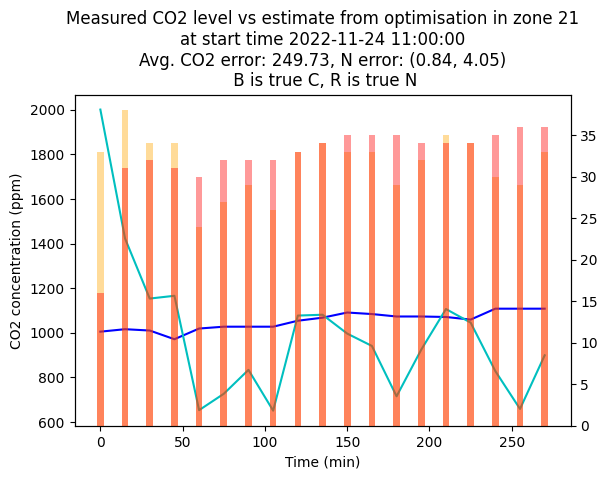

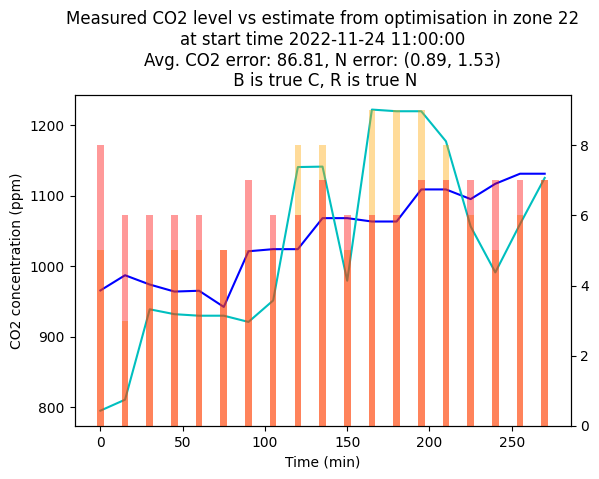

KeyboardInterrupt: 

In [10]:
hold_out(dates, plot=True, filename_parameters='testing')